In [1]:
# Importing libraries
from PIL import Image
from IPython.display import Image, display
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt 
from shapely.geometry import LineString
from shapely.geometry import Point
from itertools import combinations
import networkx as nx
from shapely.geometry import LineString
import pyvisgraph as vg

## MAIN

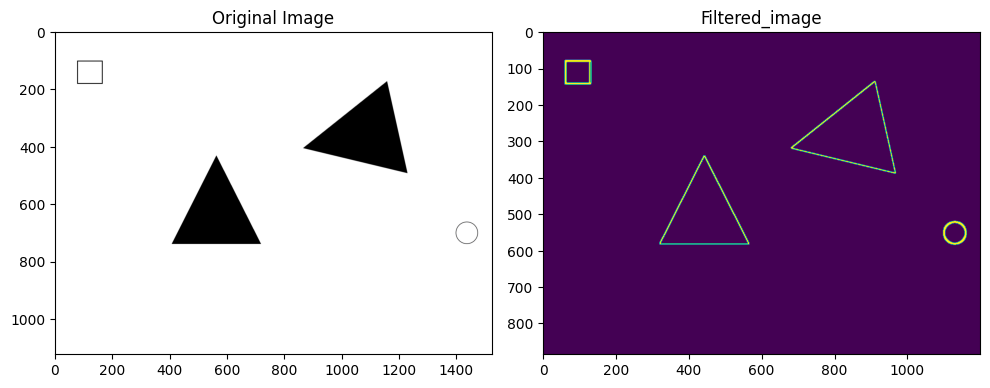

shape octagon
shape triangle
1.31
1.32
1.33
1.34
1.35
1.36
1.37
1.3800000000000001
1.3900000000000001
adequate
shape triangle
1.31
1.32
1.33
1.34
1.35
1.36
1.37
1.3800000000000001
1.3900000000000001
1.4000000000000001
1.4100000000000001
1.4200000000000002
1.4300000000000002
1.4400000000000002
adequate
shape rectangle
1.31
1.32
1.33
1.34
1.35
1.36
1.37
1.3800000000000001
1.3900000000000001
1.4000000000000001
1.4100000000000001
1.4200000000000002
1.4300000000000002
1.4400000000000002
1.4500000000000002
1.4600000000000002
1.4700000000000002
1.4800000000000002
adequate


100%|██████████| 1/1 [00:00<00:00, 249.94it/s]

[Point(336.00, 206.00), Point(617.00, 347.00), Point(1127.00, 552.00)]
1127.0 552.0
(336.00, 206.00)
(617.00, 347.00)


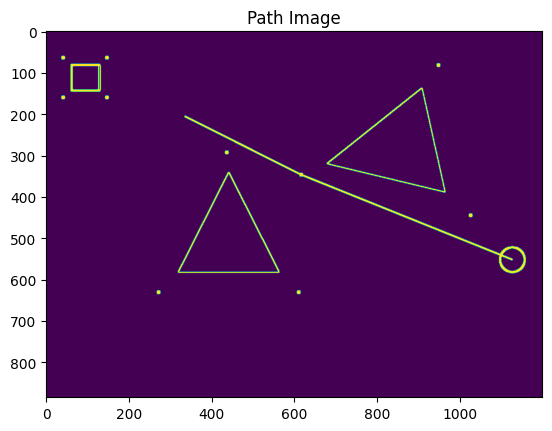

In [88]:
filename = 'visibility2.png'
#filename = 'visibility_bis.png'
#filename = 'testImages.png'

ogimg = cv2.imread(filename)

compressedimg = scale_image(ogimg)
filteredimage = filter_image(compressedimg)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Display the original image
axes[0].imshow(ogimg)
axes[0].set_title('Original Image')
axes[0].axis('on')

# Display the filtered image
axes[1].imshow(filteredimage)
axes[1].set_title('Filtered_image')
axes[1].axis('on')

plt.tight_layout()
plt.show()

# extracting the obstacle and robot positions
#Xrob_center, Yrob_center = getRobotPosition(compressedimg)
shape_vertices, (XGoal, YGoal) = extract_obstacle_goal_vertices(filteredimage, (10, 10), scale_factor)

# creating copy of image to display on
pathimage = filteredimage.copy()

# generating shortestPath
shortestPath = getShortestPath(shape_vertices, (Xrob_center, Yrob_center), (XGoal, YGoal))
# Plotting expanded shape vertices
drawPath(shape_vertices, shortestPath, pathimage)

plt.imshow(pathimage)
plt.title("Path Image")
plt.show()

## Gets the robot position
Returns a tuple representing the (x,y) position of the center of the robot

In [21]:
# INPUT: the original image in RGB
def getRobotPosition(img):
    contour = getQRContour(img)
    print(contour)
    Xrob,Yrob,Wrob,Hrob=cv2.boundingRect(contour[0])
    # Calculate the center of the rectangle
    Xrob_center = Xrob + Wrob // 2
    Yrob_center = Yrob + Hrob // 2
    return (Xrob_center, Yrob_center)
    

## Gets the contour of the QR code
Function gets the contour defining the QR_Code from the image

In [3]:
def getQRContour(img):
    # Convert the image from BGR to HSV color space
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    # converting RGB to HSV
    red = np.uint8([[[35, 25, 255 ]]])
    hsv_red = cv2.cvtColor(red,cv2.COLOR_BGR2HSV)

    # Define the lower and upper bounds for red color in HSV
    lower_red = np.array([100, 200, 200])
    upper_red = np.array([179, 255, 255])

    # Create a mask for the red QR Code
    red_mask = cv2.inRange(hsv, lower_red, upper_red)
    # getting QR code contours
    (qr_code_contour, _) = cv2.findContours(red_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    return qr_code_contour

## Scale Image

In [4]:
def scale_image(img, new_width=1200, new_height=1000):
    # Calculate the scaling factor to maintain aspect ratio
    width, height = img.shape[1], img.shape[0]
    aspect_ratio = width / height

    if width / new_width > height / new_height:
        new_height = int(new_width / aspect_ratio)
    else:
        new_width = int(new_height * aspect_ratio)

    # Resize the image while preserving the aspect ratio
    compressed_img = cv2.resize(img, (new_width, new_height))
    return compressed_img

## Filtering the image
Function filters image, by compressing the image and then enhancing the edges of the objects

In [5]:
################ Variables for Dilation Kernel #####################
# Define a kernel for dilation
kernel = np.ones((3, 3), np.uint8)

############ Variables for CANNY function ###################
lower_threshold = 100
upper_threshold = 150
aperture_size = 7 # Increase if want more details

In [6]:
def filter_image(image, new_width=1200, new_height=1000):
    gray_img = cv2.cvtColor(image, cv2.IMREAD_GRAYSCALE)

    canny_img = cv2.Canny(gray_img, lower_threshold, upper_threshold, apertureSize=aperture_size, L2gradient = True)
    # Apply dilation to make edges thicker
    dilated_edges_img = cv2.dilate(canny_img, kernel, iterations=1)
    
    return dilated_edges_img    

## Function to detect the shape of an obstacle
Function to determine type of polygon on basis of number of sides

In [7]:
 def detectShape(cnt):         
       shape = 'unknown' 
       peri=cv2.arcLength(cnt,True) 
       vertices = cv2.approxPolyDP(cnt, 0.02 * peri, True)
       sides = len(vertices) 
       if (sides == 3): 
            shape='triangle' 
       elif(sides==4): 
             x,y,w,h=cv2.boundingRect(cnt)
             aspectratio=float(w)/h 
             if (aspectratio==1):
                   shape='square'
             else:
                   shape="rectangle" 
       elif(sides==5):
            shape='pentagon' 
       elif(sides==6):
            shape='hexagon' 
       elif(sides==8): 
            shape='octagon' 
       elif(sides==10): 
            shape='star'
       else:
           shape='circle' 
       return shape 

## Extract Scaled Obstacle Goal Vertices
Returns a list of scaled vertices that define the obstacles and goal position

In [83]:
# INPUTS: canny_img; contour defining the QR_code 
# OUTPUT: list of scaled obstacle vertices; list of obstacle edges; center of the goal_position
def extract_obstacle_goal_vertices(Filtered_image, RobotPos, scale_factor):
    contours, _ = cv2.findContours(Filtered_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    shape_vertices = []
    shape_edges = [] # may not be needed
    for cnt in contours:
        shape = detectShape(cnt)
        print('shape', shape)

        ## the approxPolyDP creates a octogon to approximate the circle
        if shape == 'octagon':
            (XGoal,YGoal), radius = cv2.minEnclosingCircle(cnt)
            (XGoal,YGoal)= (int(XGoal),int(YGoal))
            radius = int(radius)
            continue

        # This will be the initial position of the robot starting top left corner   
        elif shape == 'rectangle':
            # checking if the rectangle is the robot or not by checking the position of the centers of the rectangles
            position_tolerance = 3
            X,Y,W,H=cv2.boundingRect(cnt)
            if (abs((X+(W//2)) - RobotPos[0]) < position_tolerance and abs((Y+(H//2)) - RobotPos[1]) < position_tolerance):
                print("contour is Robot")
                continue

        # for shapes that are not the goal, increase the size to account for thickness of thymio
        min_distance = 20
        cnt = scale_contour(cnt, min_distance)

        vertices = cv2.approxPolyDP(cnt, 0.02 * cv2.arcLength(cnt, True), True)
        shape = []  # Store vertices for each shape
        edges = []  # Store lines for each shape

        for i, vertex in enumerate(vertices):
            x, y = vertex[0]
            shape.append((x, y))

            next_index = 0 if i == len(vertices) - 1 else i + 1
            next_vertex = vertices[next_index][0]

            # Append edges/lines
            edges.append(((x, y), (next_vertex[0], next_vertex[1])))

        shape_vertices.append(shape)  # Append the vertices to the list
        shape_edges.append(edges)  # Append the edges to the list    
    
    return shape_vertices, (XGoal, YGoal)

    

## Scaling Contours
Function scales contours by a certain scale factor

In [79]:
# INPUTS: a contour, and minimum distance need to scale the contour
def scale_contour(original_contour, desired_min_distance):
    # Get the bounding rectangle around the shape
    x, y, w, h = cv2.boundingRect(original_contour)

    # Calculate the center of the bounding rectangle
    center = ((x + w // 2), (y + h // 2))
    
    scaled_adequate = False
    scale_factor = 1.3;
    
    while (not scaled_adequate):
        # Scale each point of the contour relative to the center
        scaled_contour = np.array([[(point[0][0] - center[0]) * scale_factor + center[0],
                                (point[0][1] - center[1]) * scale_factor + center[1]]
                               for point in original_contour], dtype=np.int32)
        #print(scaled_contour)
        # checking if contour is scaled enough
        min_distance = float('inf')

        #print(original_contour)
        for point in scaled_contour:
            point = tuple(float(coord) for coord in point)
            distance = cv2.pointPolygonTest(original_contour, point, True)
            min_distance = min(min_distance, abs(distance))
        #print(min_distance)
        if (min_distance < desired_min_distance):
            scale_factor += 0.01
            print(scale_factor)
        else:
            scaled_adequate = True
            print("adequate")
    
    return scaled_contour

## Calculating optimal path
Using PyVisGraph library, which creates an visiblity graph and uses Dijkstras algorithm to find the shortest path
Source: https://github.com/TaipanRex/pyvisgraph

In [85]:
# INPUTS: vertices of obstacles, the robot position, goal position
def getShortestPath(shape_vertices, Rob_pos, Goal_pos):
    polygons = []
    for shape in shape_vertices:
        polygon = []
        for point in shape:
            polygon.append(vg.Point(point[0], point[1]))
        polygons.append(polygon)

    graph = vg.VisGraph()
    graph.build(polygons)

    startPosition = vg.Point(Rob_pos[0],Rob_pos[1])
    endPosition = vg.Point(Goal_pos[0], Goal_pos[1])

    shortestPath = graph.shortest_path(startPosition, endPosition)
    print(shortestPath)
    goal = shortestPath[-1]
    print(goal.x, goal.y)
    return shortestPath

## DrawPath
Function visualizes the paths that is generated 

In [87]:
# INPUTS: the shortestPath: a vector of vg.Point vertices
# shape_vertices: the vertices of expanded shapes
# pathImage: the image to draw the path
def drawPath(shape_vertices, shortestPath, pathImage):
    
    for vertices in shape_vertices:
        for i, vertex in enumerate(vertices):
            x = vertex[0]
            y = vertex[1]
            cv2.circle(pathImage, (x, y), 5, (255, 0, 0), -1)  
    
    edgelist = []

    for i, node in enumerate(shortestPath[:-1]):
        print(shortestPath[i])
        edgelist.append((shortestPath[i], shortestPath[i + 1]))
        
    color = (255, 255, 255)
    thickness = 3
    for i, edge in enumerate(edgelist):
        #print(int(edgelist[i][0].x), int(edgelist[i][0].y))
        cv2.line(pathImage, (int(edgelist[i][0].x), int(edgelist[i][0].y)), (int(edgelist[i][1].x), int(edgelist[i][1].y)), color, thickness)